# TTC Delay Forecasting

In [1]:
from config import data_path

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dateutil.parser import parse

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

import time

##import libraries

In [33]:
# Defining parsing function
import re #for parsing


def standardize_time(time_str):
    # Add seconds if missing
    if len(time_str.split(':')) == 2:  # Format is h:m
        time_str += ':00'
    return time_str

def standardize_time_format(time_str):
    try:
        # Parse the time string
        parsed_time = parse(str(time_str)).time()  # Extract only the time
        # Format to HH:MM:SS
        return parsed_time.strftime('%H:%M:%S')
    except Exception as e:
        print(f"Could not parse '{time_str}': {e}")
        return None
    
def standardize_date_format(date_str):
    try:
        # Parse the date string
        parsed_date = parse(str(date_str)) 
        # Format to YYYY-MM-DD
        return parsed_date.strftime('%Y-%m-%d')
    except Exception as e:
        print(f"Could not parse '{date_str}': {e}")
        return None
    
def parse_string(s):
    try:
        s = s.lower()                   # convert to lowercase
        s = s.replace("station", "stn") # replace "station" with "stn"
        s = s.replace("&", "and")       # replace "&" with "and"
        s = s.replace("centre","center") #other spellings
        s = re.sub(r'\bu\b', 'university', s)
        s = s.replace('stn.','stn')
        s = s.replace("st. clair", "st clair")
        s = s.replace("sta", "station")

        return s
    except Exception as e:
        print(f"Could not parse '{s}': {e}")
        return None


In [35]:
def loadRawData(vehicle_type="bus",start_year = 2014, end_year = 2015, data_path = data_path):
    """
    vehicle_type = bus, subway, streetcar
    start_year = start of year range
    end_year = end of year range
    targets = targets of dataset
    features = features of dataset
    loads data, based off given parameters
    """
    # print('subfolder path', data_path)
    subfolder_path = os.path.join(data_path, vehicle_type)

    print('subfolder path', subfolder_path)
    if not os.path.isdir(subfolder_path):
            print("error")
            raise ValueError(f"Subfolder '{vehicle_type}' does not exist in {data_path}.") #making sure path is correct

    all_data = pd.DataFrame()

    for filename in os.listdir(subfolder_path):
        
        print("On filename:",filename)

        if (
            filename.endswith(".xlsx") and
            filename.startswith(f"ttc-{vehicle_type}-delay-data") and
            start_year <= int(filename.split("-")[-1].split(".")[0]) <= end_year
        ):
                file_path = os.path.join(subfolder_path, filename)
                sheet_names = pd.ExcelFile(file_path).sheet_names
                for month in sheet_names:
                    data = pd.read_excel(file_path,sheet_name=month)
                    # print(data.columns)
                    # accounting for inconsistent data formatting
                    if 'Report Date' in data.columns:
                        pass  # Column is already named "Date"
                        
                    elif 'Date' in data.columns:
                        print("Renamed date to report date")
                        data.rename(columns={'Date': 'Report Date'}, inplace=True)

                    if 'Delay' in data.columns:
                        print("Renamed Delay to Min Delay")
                        data.rename(columns={'Delay': 'Min Delay'}, inplace=True)
                    elif 'Min Delay' in data.columns:
                        pass  # Column is already named Min Delay
                    
                    all_data = pd.concat([all_data, data], ignore_index=True)    

    # all_data.info()
    # print(all_data.describe())
    # print("\n")
    return all_data

def process_data(df,targets,features,start="-01-01"):
    '''
    Takes in dataframe and preprocesses based off arguments 
    '''
    # print("Processing:\n",df.head())
    # targets = "min_delay"
    # features = ["","",""]
    # print("Using features:\n",features,"\nTargets:",targets)
    df = df.sort_index()
    df = df[targets+features] #only using necessary data
    #drop empty rows:
    df.dropna(axis=0, how='any', inplace=True) #drops where all are null
    print("Dataframe:",df.head())
    
    df['Time'] = df['Time'].apply(standardize_time_format)
    df['Report Date'] = df['Report Date'].apply(standardize_date_format)
    df['Location'] = df['Location'].apply(parse_string)

    description = df['Location'].describe()
    print("Summary Statistics:\n", description)
    unique_values_count = df['Location'].nunique()
    print(len(df['Location']))
    print(f"Number of unique values in 'Location': {unique_values_count}")

    import matplotlib.pyplot as plt


    # Plot the top 10 most common labels
    top_labels = df['Location'].value_counts().head(1000)
    top_labels_list = top_labels.index.tolist()
    print(top_labels_list)
    # for label in top_labels_list:
    #      print(label)

    top_labels.plot(kind='bar', figsize=(100, 20))

    # Set title and labels
    plt.title('Top 500 Most Frequent Labels')
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.show()



    print("Date, location, time dataframe:\n",df.head())
    
    df['Datetime'] = pd.to_datetime((df['Report Date'] + ' ' + df['Time']),format='%Y-%m-%d %H:%M:%S') #combining into one column

    #dropping the unecessary columns:
    df.drop(columns = ['Time','Report Date'], inplace = True)
    # print(df.columns)

    # preprocessing the direction to make consistent 4 + 1 directions 
    valid_directions = ['n','s','e','w','b'] #should only have n,e,s,w, b - both ways

    df['Direction'] = df['Direction'].str[0].str.lower()
    df['Direction'] = df['Direction'].apply(lambda x: x if x in valid_directions else 'unknown')
    


    #one hot encoding
    
    categorical_features = df.select_dtypes(include=['object']).columns # only categorical features selected
    print("there are this many unique columns",len(categorical_features),categorical_features)
    

    # categorical_features = ['Route','Direction']
    for features in categorical_features:
        df[features] = df[features].astype(str)


    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded_features = encoder.fit_transform(df[categorical_features])
    
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
    df = pd.concat([df, encoded_df], axis=1)

    df.drop(categorical_features, axis=1, inplace=True) #removing unecessary columns

    df.set_index('Datetime',inplace=True)

    # Extract year, month, day, hour, and minute from the Datetime index
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute

     
    scaler = RobustScaler()
    # scaler = StandardScaler() #standard because we expect standard deviation
    # scaler = MinMaxScaler() #min max because ...

    df[['Min Delay']] = scaler.fit_transform(df[['Min Delay']])
    df.dropna(axis=0, how='any', inplace=True)

    df = df.sort_index()
    print(df.head())
    
 
    return df,scaler

In [ ]:
# from data_load import *

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


def create_sliding_windows(df, n_steps, n_outputs, target_column):
    """
    Converts a DataFrame into overlapping sliding windows.

    Parameters:
    - df: Input DataFrame with features and target variable.
    - n_steps: Number of time steps in the input sequence.
    - n_outputs: Number of time steps in the output sequence.
    - target_column: Name or index of the target column.

    Returns:
    - X: Numpy array of shape (num_samples, n_steps, num_features)
    - y: Numpy array of shape (num_samples, n_outputs)
    """
    X, y = [], []
    if isinstance(target_column, str):
        target_index = df.columns.get_loc(target_column)  # Get column index
    else:
        target_index = target_column

    data = df.to_numpy()  # Convert to NumPy for efficiency
    for i in range(len(data) - n_steps - n_outputs + 1):
        # Include all columns except the target in X
        X.append(data[i:i + n_steps, :])
        # Use only the target column for y
        y.append(data[i + n_steps:i + n_steps + n_outputs, target_index])
    X = np.array(X)
    y = np.array(y)

    # Exclude the target column from X (optional if the target is among features)
    # X = np.delete(X, target_index, axis=-1)
    return X, y

2024-12-02 22:39:42.587629: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 22:39:42.605820: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 22:39:42.611245: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 22:39:42.625476: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 22:39:43.422489: W tensorflow/comp

In [5]:
#getting data
vehicle_type = 'bus'
start_year = 2014 #min
end_year = 2024 #max

#number of outputs: (how many points ahead to forecast)s

n_outputs = 8 #forecasting 1 hours of delays(4 |delays / hour * 2 hours)
n_steps = 50# how many points to use # assuming about 4 delays per hour * 24 hours / day ~ 100 points of data

targets = ["Min Delay"]
features = ["Report Date", "Time","Direction", "Location", "Route"]

print("Loading data")
df = loadRawData(vehicle_type=vehicle_type,start_year=start_year,end_year=end_year)
print("Finished loading data")

Loading data
subfolder path /media/jadenh/SSD2/TTC_DATA/bus
On filename: ttc-bus-delay-data-2014.xlsx
On filename: ttc-bus-delay-data-2015.xlsx
On filename: ttc-bus-delay-data-2016.xlsx
On filename: ttc-bus-delay-data-2017.xlsx
On filename: ttc-bus-delay-data-2018.xlsx
On filename: ttc-bus-delay-data-2019.xlsx
Renamed Delay to Min Delay
Renamed Delay to Min Delay
Renamed Delay to Min Delay
Renamed Delay to Min Delay
On filename: ttc-bus-delay-data-2020.xlsx
Renamed Delay to Min Delay
Renamed Delay to Min Delay
Renamed Delay to Min Delay
Renamed Delay to Min Delay
Renamed Delay to Min Delay
Renamed Delay to Min Delay
Renamed Delay to Min Delay
Renamed date to report date
Renamed date to report date
Renamed date to report date
Renamed date to report date
Renamed date to report date
On filename: ttc-bus-delay-data-2021.xlsx
Renamed date to report date
Renamed date to report date
Renamed date to report date
Renamed date to report date
Renamed date to report date
Renamed date to report date

Dataframe:    Min Delay Report Date      Time Direction              Location  Route
0       10.0  2014-01-01  00:23:00         E    York Mills station   95.0
1       33.0  2014-01-01  00:55:00       b/w  Entire run for route  102.0
2       10.0  2014-01-01  01:28:00        WB   lawrence and Warden   54.0
3       18.0  2014-01-01  01:30:00         N       Kipling Station  112.0
4       10.0  2014-01-01  01:37:00         n      VP and Ellesmere   24.0
Summary Statistics:
 count          637681
unique          97702
top       kennedy stn
freq            14787
Name: Location, dtype: object
637681
Number of unique values in 'Location': 97702
['kennedy stn', 'finch stn', 'warden stn', 'kipling stn', 'eglinton stn', 'wilson stn', 'entire route', 'downsview stn', 'pape stn', 'stc', 'victoria park stn', 'york mills stn', 'don mills stn', 'main stn', 'keele stn', 'eglinton west stn', 'scarborough town center', 'broadview stn', 'jane stn', 'lawrence stn', 'lawrence west stn', 'islington stn', 's

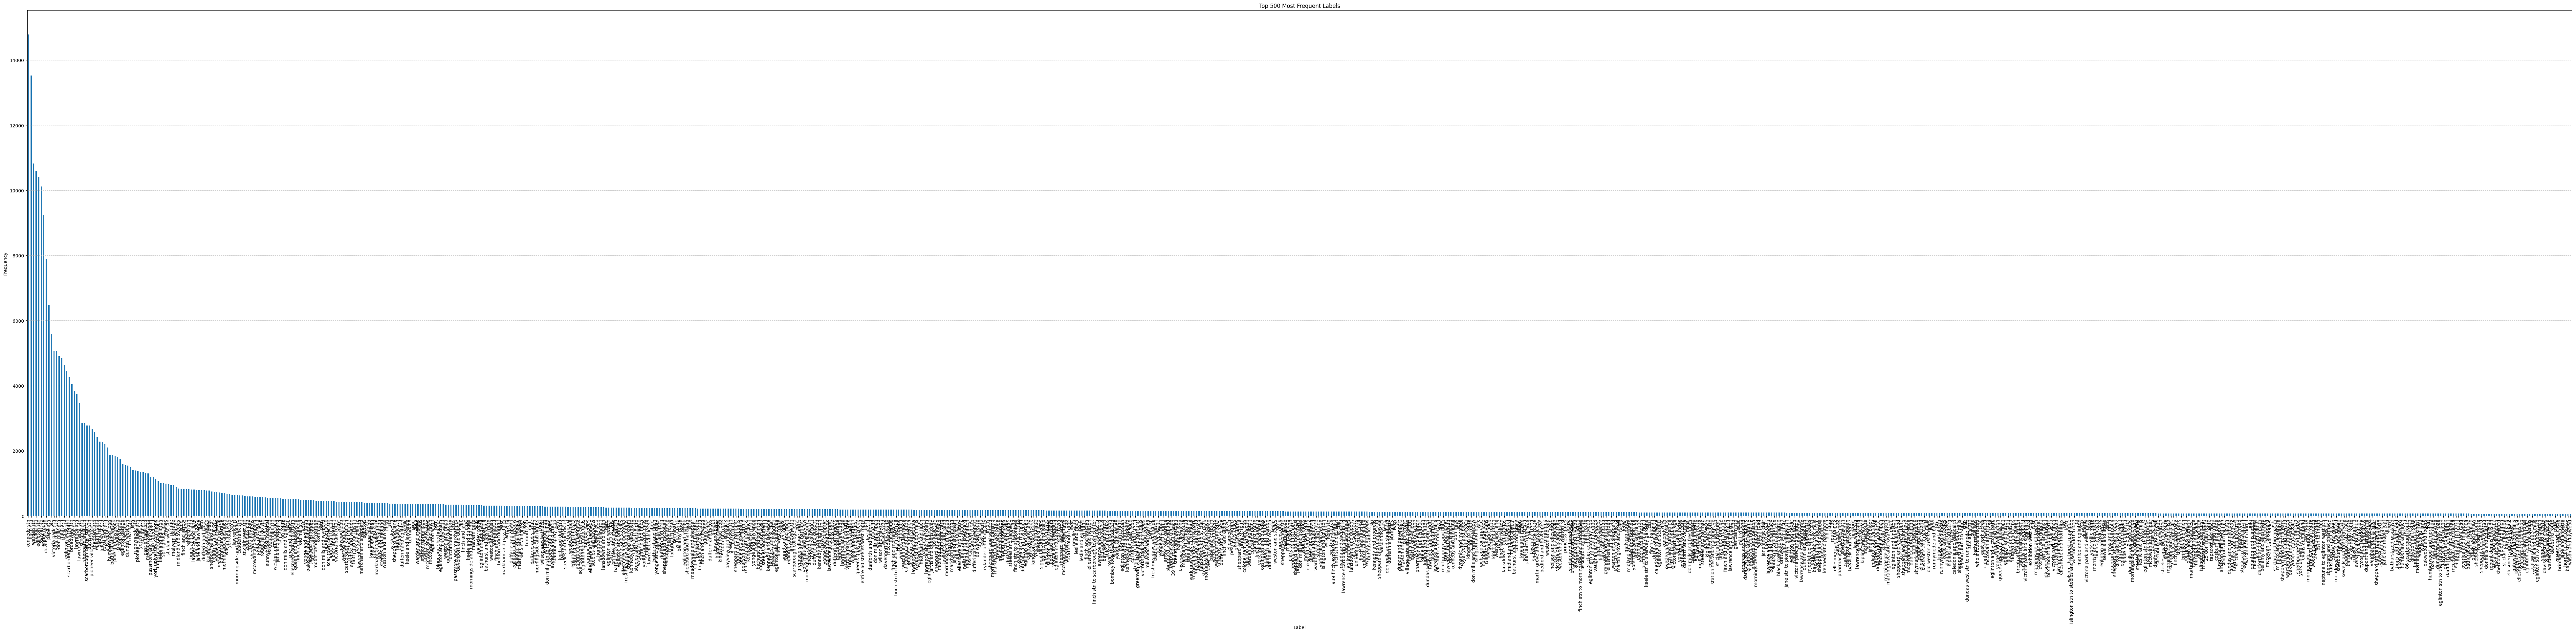

Date, location, time dataframe:
    Min Delay Report Date      Time Direction              Location  Route
0       10.0  2014-01-01  00:23:00         E        york mills stn   95.0
1       33.0  2014-01-01  00:55:00       b/w  entire run for route  102.0
2       10.0  2014-01-01  01:28:00        WB   lawrence and warden   54.0
3       18.0  2014-01-01  01:30:00         N           kipling stn  112.0
4       10.0  2014-01-01  01:37:00         n      vp and ellesmere   24.0
there are this many unique columns 3 Index(['Direction', 'Location', 'Route'], dtype='object')


MemoryError: Unable to allocate 468. GiB for an array with shape (637681, 98479) and data type float64

In [36]:
## Processing Data

df_process,scaler = process_data(df,targets=targets,features=features)

print(df_process.head())

X, y = create_sliding_windows(df_process,n_steps,n_outputs,target_column=targets[0])


#splitting data
test_size = 0.2
split_index = int(len(df_process) * (1 - test_size))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]



# X_train, X_test, y_train, y_test, scaler = getXandY(n_outputs,n_steps,targets, features, vehicle_type=vehicle_type,start_year=start_year,end_year = end_year)



print("Finished loading data")

print("x train shape:", X_train.shape)
print("x test shape:", X_test.shape)
print("y train shape:", y_train.shape)
print("y test shape:", y_test.shape)

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
# LSTM model
## Creating models

#parameters:
adam_lr = 0.0001
num_neurons = 64
batch_size = 512
num_epochs = 10

#making a lr_schedule
def step_decay(epoch, lr):
    # Reduce LR by 50% after each epoch
    return lr * 0.5

lr_schedule = LearningRateScheduler(step_decay)


input_shape = (X_train.shape[0],X_train.shape[2]) #num samples, num features in each sample


lstm_model = models.Sequential()
# lstm_model.add(layers.BatchNormalization())
lstm_model.add(layers.LSTM(num_neurons,
                           activation='relu',
                           return_sequences=True, #so we can use multiple lstm layers
                           input_shape=input_shape))
lstm_model.add(layers.BatchNormalization())
lstm_model.add(layers.Dropout(0.3))
lstm_model.add(layers.LSTM(num_neurons//2,
                           activation='relu'))
lstm_model.add(layers.Dropout(0.3))
# lstm_model.add(layers.BatchNormalization())

lstm_model.add(layers.Dense(1))  # for the final output layer since its only 1 output


optimizer = Adam(learning_rate=adam_lr)#, clipnorm=1.0) #setting 

lstm_model.compile(optimizer=optimizer, metrics = ['mae'], loss='mse')  #use mae and mse since regression

# creating model
lstm_model.summary()

#fitting model
start_time = time.time()
history = lstm_model.fit(X_train,y_train,
                    epochs = num_epochs,
                    batch_size = batch_size,
                    callbacks=[lr_schedule],
                    validation_split=0.2, #0.2 of the training set to be used for validation
                    shuffle=False,
                    verbose=1)
end_time = time.time()

print("Total time: {0} s".format(round((end_time-start_time),2)))


In [ ]:
#Testing model:
# getting predictions of model:
y_test_pred = lstm_model.predict(X_test)
y_train_pred = lstm_model.predict(X_train)

train_loss, train_mae = lstm_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mae = lstm_model.evaluate(X_test, y_test, verbose=0)

# # print("Predictions:", y_pred)

# Print model evaluation results
print(f"TensorFlow Evaluation:")
print(f"Training Loss (MSE): {train_loss:.4f}, Training MAE: {train_mae:.4f}")
print(f"Testing Loss (MSE): {test_loss:.4f}, Testing MAE: {test_mae:.4f}")


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_predictions_vs_real(y_test, y_test_pred, X_test, scaler, output_index=0, title="Predictions vs Actual"):
    """
    Plots the predicted vs actual values on separate plots, limited to the last month.
    
    Parameters:
    - y_test: Ground truth values (2D array with shape [samples, n_outputs]).
    - y_test_pred: Predicted values (2D array with shape [samples, n_outputs]).
    - X_test: Input features (3D array with time steps and features).
    - scaler: Scaler used to scale the data (e.g., StandardScaler).
    - output_index: Index of the output time step you want to plot (0-based).
    - title: Title for the plot.
    """
    # Extract only the output_index-th output for both y_test and y_test_pred
    y_test_single = y_test[:, output_index]
    y_test_pred_single = y_test_pred[:, output_index]

    # Ensure data is 1D
    y_test_single = y_test_single.flatten()
    y_test_pred_single = y_test_pred_single.flatten()

    # Unscale the data
    y_test_unscaled = scaler.inverse_transform(y_test_single.reshape(-1, 1)).flatten()
    y_test_pred_unscaled = scaler.inverse_transform(y_test_pred_single.reshape(-1, 1)).flatten()

    # Extract datetime features from X_test
    datetime_features = X_test[:, :, -5:]  # Last 5 columns for datetime features (year, month, etc.)
    last_timestep_datetime = datetime_features[:, -1, :]  # Take datetime info from the last time step

    # Create a DataFrame for datetime information
    # datetime_df = pd.DataFrame(last_timestep_datetime, columns=['year', 'month', 'day', 'hour', 'minute'])
    # datetime_df['datetime'] = pd.to_datetime(datetime_df[['year', 'month', 'day', 'hour', 'minute']])
    datetime_df = pd.DataFrame(last_timestep_datetime, columns=['year', 'month', 'day', 'hour'])
    datetime_df['datetime'] = pd.to_datetime(datetime_df[['year', 'month', 'day', 'hour']])


    # Filter the datetime range to the last month
    datetime_df['datetime'] = pd.to_datetime(datetime_df['datetime'])
    last_month = datetime_df['datetime'].max() - pd.DateOffset(months=1)
    datetime_df = datetime_df[datetime_df['datetime'] >= last_month]

    # Filter the data for the last month
    y_test_unscaled_month = y_test_unscaled[datetime_df.index]
    y_test_pred_unscaled_month = y_test_pred_unscaled[datetime_df.index]

    # Plotting the results with separate plots for actual and predicted values
    fig, axs = plt.subplots(2, 1, figsize=(18, 6), sharex=True)

    # Plot actual values
    axs[0].plot(datetime_df['datetime'], y_test_unscaled_month, label="Actual", color="blue", alpha=0.7)
    axs[0].set_ylabel("Actual Delay (minutes)")
    axs[0].set_ylim(bottom=0)
    axs[0].grid(True)

    # Plot predicted values
    axs[1].plot(datetime_df['datetime'], y_test_pred_unscaled_month, label="Predicted", color="red", alpha=0.7)
    axs[1].set_xlabel("Date and Time")
    axs[1].set_ylabel("Predicted Delay (minutes)")
    axs[1].set_ylim(bottom=0)
    axs[1].grid(True)

    # Set the main title for the entire figure
    fig.suptitle(title, fontsize=16)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


# Call the plotting function
plot_predictions_vs_real(y_test, y_test_pred, X_test, scaler, output_index=0)


In [ ]:
input_shape = (X_train.shape[0], X_train.shape[2])  # num samples, num features in each sample

# GRU model
gru_model = models.Sequential()
gru_model.add(layers.GRU(num_neurons,
                         activation='relu',
                         return_sequences=True,  # so we can use multiple GRU layers
                         input_shape=input_shape))
gru_model.add(layers.Dropout(0.3))
gru_model.add(layers.GRU(num_neurons//2,
                         activation='relu'))
gru_model.add(layers.Dropout(0.3))
gru_model.add(layers.Dense(1))  # for the final output layer since it's only 1 output

optimizer = Adam(learning_rate=adam_lr)  # setting optimizer

gru_model.compile(optimizer=optimizer, metrics=['mae'], loss='mse')  # use mae for regression

# creating model
gru_model.summary()

# fitting model
start_time = time.time()
gru_history = gru_model.fit(X_train, y_train,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        validation_split=0.2,  # 0.2 of the training set to be used for validation
                        verbose=1)
end_time = time.time()

print("Total time: {0} s".format(round((end_time - start_time), 2)))

In [ ]:
#Testing model:
# getting predictions of model:
y_test_pred = gru_model.predict(X_test)
y_train_pred = gru_model.predict(X_train)

train_loss, train_mae = gru_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mae = gru_model.evaluate(X_test, y_test, verbose=0)

# # print("Predictions:", y_pred)

# Print model evaluation results
print(f"TensorFlow Evaluation:")
print(f"Training Loss (MSE): {train_loss:.4f}, Training MAE: {train_mae:.4f}")
print(f"Testing Loss (MSE): {test_loss:.4f}, Testing MAE: {test_mae:.4f}")


plt.plot(gru_history.history['loss'], label='Training Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [ ]:
plot_predictions_vs_real(y_test, y_test_pred, X_test, scaler, output_index=0)

In [ ]:
# RNN model
rnn_model = models.Sequential()
rnn_model.add(layers.SimpleRNN(num_neurons,
                               activation='relu',
                               return_sequences=True,  # so we can use multiple RNN layers
                               input_shape=input_shape))
rnn_model.add(layers.Dropout(0.3))
rnn_model.add(layers.SimpleRNN(num_neurons//2,
                               activation='relu'))
rnn_model.add(layers.Dropout(0.3))
rnn_model.add(layers.Dense(1))  # for the final output layer since it's only 1 output

optimizer = Adam(learning_rate=adam_lr)  # setting optimizer

rnn_model.compile(optimizer=optimizer, metrics=['mae'], loss='mse')  # use mae for regression

# creating model
rnn_model.summary()

# fitting model
start_time = time.time()
rnn_history = rnn_model.fit(X_train, y_train,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        validation_split=0.2,  # 0.2 of the training set to be used for validation
                        verbose=1)
end_time = time.time()

print("Total time: {0} s".format(round((end_time - start_time), 2)))


In [ ]:
#Testing model:
# getting predictions of model:
y_test_pred = rnn_model.predict(X_test)
y_train_pred = rnn_model.predict(X_train)

train_loss, train_mae = rnn_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mae = rnn_model.evaluate(X_test, y_test, verbose=0)

# # print("Predictions:", y_pred)

# Print model evaluation results
print(f"TensorFlow Evaluation:")
print(f"Training Loss (MSE): {train_loss:.4f}, Training MAE: {train_mae:.4f}")
print(f"Testing Loss (MSE): {test_loss:.4f}, Testing MAE: {test_mae:.4f}")


plt.plot(rnn_history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [ ]:
# output_index = 0
# title = "x"
# y_test_single = y_test[:, output_index]
# y_test_pred_single = y_test_pred[:, output_index]

# # Ensure data is 1D
# y_test_single = y_test_single.flatten()
# y_test_pred_single = y_test_pred_single.flatten()

# # Unscale the data
# y_test_unscaled = scaler.inverse_transform(y_test_single.reshape(-1, 1)).flatten()
# y_test_pred_unscaled = scaler.inverse_transform(y_test_pred_single.reshape(-1, 1)).flatten()

# # Extract datetime features from X_test
# datetime_features = X_test[:, :, -5:]  # Last 5 columns for datetime features (year, month, etc.)
# last_timestep_datetime = datetime_features[:, -1, :]  # Take datetime info from the last time step

# # Create a DataFrame for datetime information
# datetime_df = pd.DataFrame(last_timestep_datetime, columns=['year', 'month', 'day', 'hour', 'minute'])
# datetime_df['datetime'] = pd.to_datetime(datetime_df[['year', 'month', 'day', 'hour', 'minute']])

# # Filter the datetime range to the last month
# datetime_df['datetime'] = pd.to_datetime(datetime_df['datetime'])
# last_month = datetime_df['datetime'].max() - pd.DateOffset(months=1)
# datetime_df = datetime_df[datetime_df['datetime'] >= last_month]

# # Filter the data for the last month
# y_test_unscaled_month = y_test_unscaled[datetime_df.index]
# y_test_pred_unscaled_month = y_test_pred_unscaled[datetime_df.index]

# # Plotting the results on the same plot
# plt.figure(figsize=(18, 6))

# # Plot actual values
# # plt.plot(datetime_df['datetime'], y_test_unscaled_month, label="Actual", color="blue", alpha=0.7)

# # Plot predicted values
# plt.plot(datetime_df['datetime'], y_test_pred_unscaled_month, label="Predicted", color="red", alpha=0.7)

# # Labels and title
# plt.xlabel("Date and Time")
# plt.ylabel("Delay (minutes)")
# plt.title(title, fontsize=16)
# plt.legend()
# plt.grid(True)

# # Show the plot
# plt.tight_layout()
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# def plot_forecast_only(forecasted_values_unscaled, X_test, title="Forecast for Next 30 Days"):
#     """
#     Plots the forecasted values for the next 30 days.

#     Parameters:
#     - forecasted_values_unscaled: Predicted values for the next 30 days (1D array of length 30).
#     - X_test: The input data (to extract datetime information).
#     - title: Title for the plot.
#     """
#     # Extract datetime information from the last window of X_test
#     datetime_features = X_test[-1, :, -5:]  # Last window (most recent window) from X_test
#     last_timestep_datetime = datetime_features[-1, :]  # Get the last timestep's datetime
#     datetime_df = pd.DataFrame([last_timestep_datetime], columns=['year', 'month', 'day', 'hour', 'minute'])
    
#     # Convert to scalar datetime
#     last_datetime = pd.to_datetime(datetime_df.iloc[0])
    
#     # Generate the datetime range
#     datetime_range = last_datetime + pd.to_timedelta(np.arange(30), unit='D')

#     # Check if forecasted values and datetime range match
#     if len(forecasted_values_unscaled) != len(datetime_range):
#         raise ValueError(
#             f"Mismatch in dimensions: forecasted_values_unscaled={len(forecasted_values_unscaled)}, "
#             f"datetime_range={len(datetime_range)}"
#         )

#     # Plot the forecasted values for the next 30 days
#     plt.figure(figsize=(12, 6))
#     plt.plot(datetime_range, forecasted_values_unscaled, label="Forecasted", color="red", alpha=0.7)
#     plt.title(title)
#     plt.xlabel("Time")
#     plt.ylabel("Values")
#     plt.legend()
#     plt.grid(True)
#     plt.show()


# # Step 1: Get the last window of data
# last_window = X_test[-1]  # The last sliding window (most recent data)

# # Step 2: Reshape the input data for prediction (LSTM expects 3D input: [samples, timesteps, features])
# last_window = last_window.reshape((1, last_window.shape[0], last_window.shape[1]))  # Shape: (1, n_steps, n_features)

# # Step 3: Predict the next 30 days
# forecasted_values = lstm_model.predict(last_window, batch_size=1)

# # Step 4: Reshape the forecasted values (correctly)
# forecasted_values = forecasted_values.flatten()  # Ensure it's a flat array with 30 elements

# # Step 5: If you used a scaler for your target variable, unscale the predictions
# forecasted_values_unscaled = lstm_scaler.inverse_transform(forecasted_values.reshape(-1, 1)).flatten()

# # Call the plotting function with forecasted values
# plot_forecast_only(forecasted_values_unscaled, X_test)

